<a href="https://colab.research.google.com/github/phanducminh201/Model_training_in_ML/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import libraries**

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# **2. Data description**

**Bối cảnh:** Bộ dữ liệu này ban đầu đến từ Viện Quốc gia về Bệnh tiểu đường, Tiêu hóa và Thận. Mục tiêu của bộ dữ liệu là dự đoán bệnh nhân có bị tiểu đường hay không, dựa trên một số phép đo chẩn đoán có trong bộ dữ liệu. Một số hạn chế đã được đặt ra khi lựa chọn các trường hợp này từ cơ sở dữ liệu lớn hơn. Đặc biệt, tất cả bệnh nhân ở đây đều là phụ nữ ít nhất 21 tuổi có nguồn gốc là người da đỏ Pima.

**Dataset Description:**

Pregnancies: Number of times pregnant

Glucose: Plasma glucose concentration over 2 hours in an oral glucose tolerance test

BloodPressure: Diastolic blood pressure (mm Hg)

SkinThickness: Triceps skinfold thickness (mm)

Insulin: 2-Hour serum insulin (mu U/ml)

BMI: Body mass index (weight in kg/(height in m)^2)

Pedigree: Diabetes pedigree function - A function that scores likelihood of diabetes based on family history.

Age: Age in years

Outcome: Class variable (0: the person is not diabetic or 1: the person is diabetic)

# **3. Import dataset**

In [48]:
data = pd.read_csv('diabetes.csv')
data.shape

(768, 9)

In [49]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# **4. Preprocessing data**

In [51]:
data.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


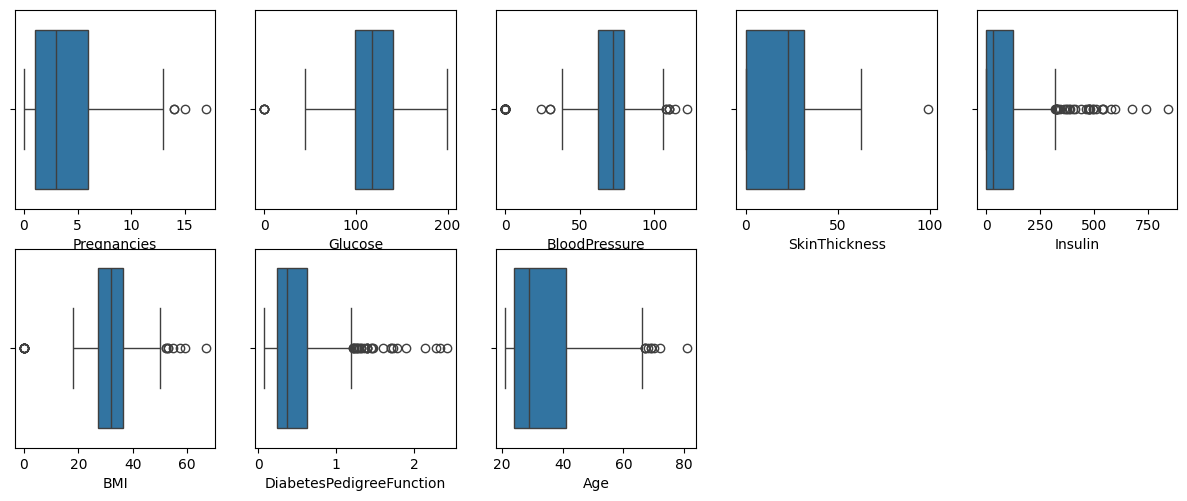

In [52]:
plt.figure(figsize = (15,15))
for i, col in enumerate(["Pregnancies","Glucose","BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]):
    plt.subplot(5, 5, i+1)
    sns.boxplot(x = col, data = data)
plt.show()

In [53]:
outlier_indices = set()
outlier_data = pd.DataFrame()
for col in data.select_dtypes(["float64", "int64"]).columns:
  q1 = data[col].quantile(0.25)
  q3 = data[col].quantile(0.75)
  iqr = q3 - q1

  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr

  outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
  outlier_indices.update(outliers.index)
  outlier_data = pd.concat([outlier_data, outliers], axis=0)

outlier_data = outlier_data.drop_duplicates()

In [54]:
data_cleaned=data.drop(outlier_indices).reset_index(drop=True)
print(data_cleaned.shape)

(639, 9)


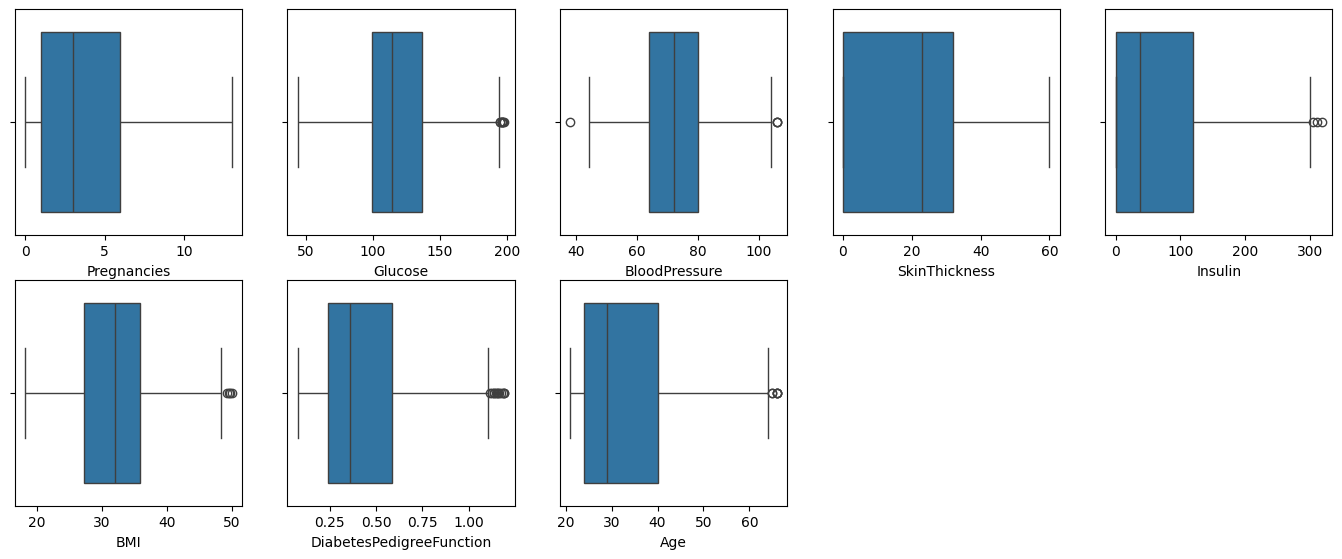

In [55]:
plt.figure(figsize = (17,17))
for i, col in enumerate(["Pregnancies","Glucose","BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]):
    plt.subplot(5, 5, i+1)
    sns.boxplot(x = col, data = data_cleaned)
plt.show()

In [56]:
data_cleaned

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
634,10,101,76,48,180,32.9,0.171,63,0
635,2,122,70,27,0,36.8,0.340,27,0
636,5,121,72,23,112,26.2,0.245,30,0
637,1,126,60,0,0,30.1,0.349,47,1


**Correlation heatmap**

<Axes: >

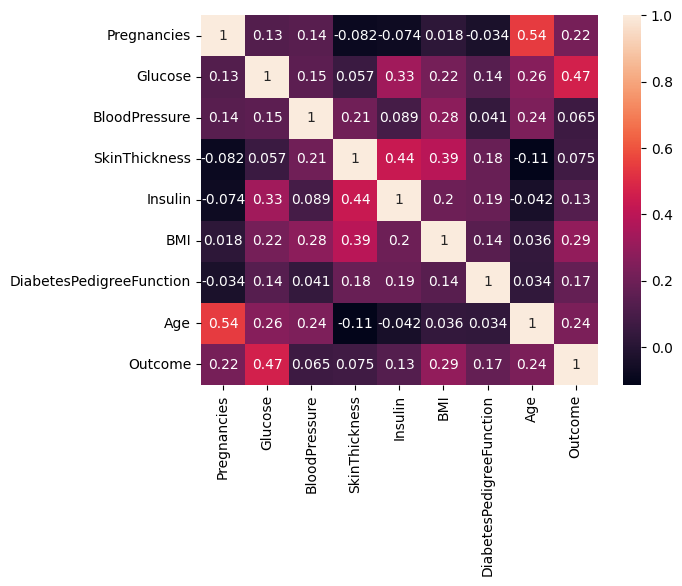

In [57]:
corr_matrix_pearson = data.corr(method='pearson')
corr_matrix_pearson
sns.heatmap(corr_matrix_pearson, annot = True)

# **5. Declare feature vector and target variable**

In [58]:
X = data_cleaned[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].values
y = data_cleaned['Outcome'].values

# **6. Split data into separate training and test set**

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [60]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# **7. Model training without library**

**7.1 Decision tree algorithm**

In [61]:
class Node:
  def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value

  def is_leaf_node(self):
    return self.value is not None


class DecisionTree:
  def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
    self.min_samples_split=min_samples_split
    self.max_depth=max_depth
    self.n_features=n_features
    self.root=None

  def fit(self, X, y):
    self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
    self.root = self._grow_tree(X, y)

  def _grow_tree(self, X, y, depth=0):
    n_samples, n_feats = X.shape
    n_labels = len(np.unique(y))

    if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
      leaf_value = self._most_common_label(y)
      return Node(value=leaf_value)

    feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

    best_feature, best_thresh = self._best_split(X, y, feat_idxs)

    left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
    left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
    right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
    return Node(best_feature, best_thresh, left, right)

  def _best_split(self, X, y, feat_idxs):
    best_gain = -1
    split_idx, split_threshold = None, None

    for feat_idx in feat_idxs:
      X_column = X[:, feat_idx]
      thresholds = np.unique(X_column)

      for thr in thresholds:
        gain = self._information_gain(y, X_column, thr)

        if gain > best_gain:
          best_gain = gain
          split_idx = feat_idx
          split_threshold = thr

    return split_idx, split_threshold

  def _information_gain(self, y, X_column, threshold):
    parent_entropy = self._entropy(y)

    left_idxs, right_idxs = self._split(X_column, threshold)

    if len(left_idxs) == 0 or len(right_idxs) == 0:
      return 0

    n = len(y)
    n_l, n_r = len(left_idxs), len(right_idxs)
    e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
    child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

    information_gain = parent_entropy - child_entropy
    return information_gain

  def _split(self, X_column, split_thresh):
    left_idxs = np.argwhere(X_column <= split_thresh).flatten()
    right_idxs = np.argwhere(X_column > split_thresh).flatten()
    return left_idxs, right_idxs

  def _entropy(self, y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p>0])

  def _most_common_label(self, y):
    counter = Counter(y)
    value = counter.most_common(1)[0][0]
    return value

  def predict(self, X):
    return np.array([self._traverse_tree(x, self.root) for x in X])

  def _traverse_tree(self, x, node):
    if node.is_leaf_node():
      return node.value

    if x[node.feature] <= node.threshold:
      return self._traverse_tree(x, node.left)
    return self._traverse_tree(x, node.right)

In [62]:
# Counter({'z': 5, 'x': 4, 'y': 2})
# [('z', 5)]
# ('z', 5)
# z

**7.2 Caculating accuracy**

In [63]:
def accuracy(y_test, y_pred):
  return (np.sum(y_test == y_pred) / len(y_test))*100

**7.3 Random forest algorithm**

In [64]:
class RandomForest:
  def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_features=None):
    self.n_trees = n_trees
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.n_features = n_features
    self.trees = []

  def fit(self, X, y):
    self.trees = []
    for _ in range(self.n_trees):
      tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, n_features=self.n_features)
      X_sample, y_sample = self._bootstrap_sample(X, y)
      tree.fit(X_sample, y_sample)
      self.trees.append(tree)

  def _bootstrap_sample(self, X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

  def _most_common_label(self, y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

  def predict(self, X):
    predictions = np.array([tree.predict(X) for tree in self.trees])
    tree_preds = np.swapaxes(predictions, 0, 1)
    predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
    return predictions

In [65]:
# [n_trees, n_sample]
# (3,4)
# [[1, 0, 1, 1]
# [1, 1, 0, 0]
# [0 ,1, 0, 1]]

# [n_sample, n_trees]
# => (4,3)
# [[1, 1, 0] 1
# [0, 1, 1] 1
# [1, 0, 0] 0
# [1, 0, 1]] 1

**7.4 Model training**

In [66]:
rf = RandomForest(n_trees=30, max_depth=20, n_features=6)
rf.fit(X_train, y_train)

In [67]:
y_pred = rf.predict(X_test)
y_pred

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0])

**7.5 Model evaluation**

In [68]:
acc = accuracy(y_test, y_pred)
print(acc, "%")

79.375 %


In [69]:
dcx = accuracy_score(y_test, y_pred)
print(dcx)

0.79375


**7.5 Confusion matrix**

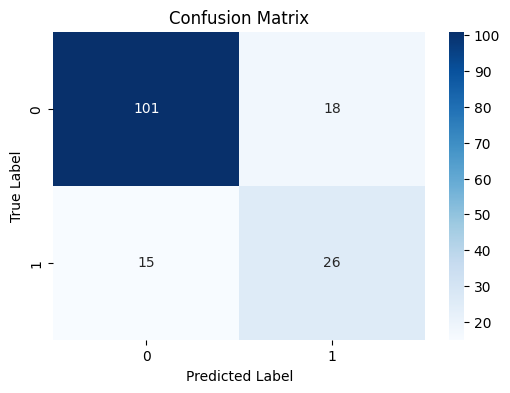

In [70]:
plt.figure(figsize=(6,4))


cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

\begin{equation}
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation}

\begin{equation}
Recall = \frac{TP}{TP + FN}
\end{equation}

\begin{equation}
Precision = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
F1-Score = 2.\frac{Precision.Recall}{Precision + Recall}
\end{equation}

In [71]:
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred),2)}")
print(f"Precision   : {round(precision_score(y_test, y_pred), 2)}")
print(f"F1: {round(f1_score(y_test, y_pred), 2)}")

Accuracy: 0.79
Recall: 0.63
Precision   : 0.59
F1: 0.61


**7.6 Classification report**

\begin{equation}
Macro \quad avg = \frac{1}{N} \sum_{i=1}^N M_i, \text{trong đó:} \\
\text{N: số lượng lớp} \\
\text{$M_i$: các giá trị precision, recall, f1-score của lớp thứ i}
\end{equation}


\begin{equation}
Weighted \quad avg = \frac{1}{\sum_{i=1}^N s_i} \sum _{i=1}^N s_i . M_i, \text{trong đó:} \\
\text{$s_i:$ số mẫu (support) của lớp thứ i} \\
\text{$M_i$: các giá trị precision, recall, f1-score của lớp thứ i}
\end{equation}

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       119
           1       0.59      0.63      0.61        41

    accuracy                           0.79       160
   macro avg       0.73      0.74      0.74       160
weighted avg       0.80      0.79      0.80       160



# **8. Model training with Scikit-learn**

**8.1 Model training**

In [73]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=10)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, random_state=10)

In [74]:
y_predictions = model_rf.predict(X_test)
y_predictions

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0])

**8.2 Model evaluation**

In [75]:
acc = accuracy(y_test, y_predictions)
print(acc, "%")

75.625 %


In [76]:
dcx_ = accuracy_score(y_test, y_predictions)
print(dcx_)

0.75625


**8.3 Confusion matrix**

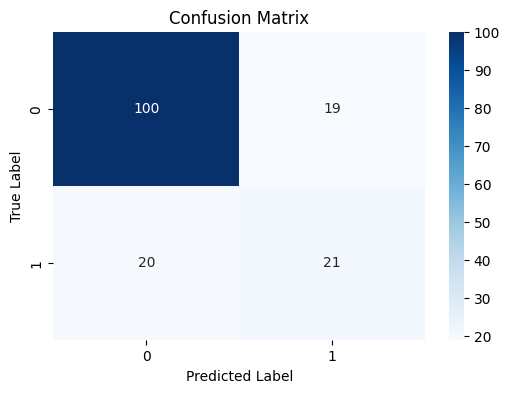

In [77]:
plt.figure(figsize=(6,4))


cm = confusion_matrix(y_test, y_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [78]:
print(f"Accuracy: {round(accuracy_score(y_test, y_predictions), 2)}")
print(f"Recall: {round(recall_score(y_test, y_predictions),2)}")
print(f"Precision: {round(precision_score(y_test, y_predictions), 2)}")
print(f"F1: {round(f1_score(y_test, y_predictions), 2)}")

Accuracy: 0.76
Recall: 0.51
Precision: 0.53
F1: 0.52


In [79]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       119
           1       0.53      0.51      0.52        41

    accuracy                           0.76       160
   macro avg       0.68      0.68      0.68       160
weighted avg       0.75      0.76      0.76       160



**8.4 Features important**

In [81]:
feature_scores = pd.Series(model_rf.feature_importances_, index=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'BMI', 'DiabetesPedigreeFunction', 'Age']).sort_values(ascending=False)

feature_scores

,0
Glucose,0.270677
BMI,0.157275
Age,0.149870
DiabetesPedigreeFunction,0.143289
Pregnancies,0.100479
BloodPressure,0.092828
SkinThickness,0.085582


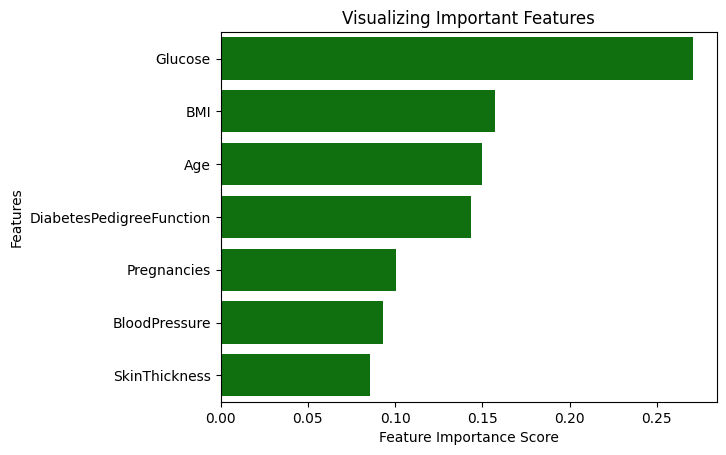

In [82]:
sns.barplot(x=feature_scores, y=feature_scores.index, color='green')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# **9. Results and conclusion**